<a href="https://colab.research.google.com/github/ray021207/Comparative-Study-of-Approaches-for-Injury-Risk-Prediction-in-Athletes/blob/main/new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
!pip install scikit-learn
from sklearn.utils import resample
df = pd.read_csv("mhealth_full.csv")


In [3]:

# 2. Separate features and labels
X = df.drop(columns=['activity_label', 'subject'])
y = df['activity_label']

# 3. Handle missing values (if any)
# Optional: check for missing values
print("Missing values per column:\n", X.isnull().sum())

# For now, drop any rows with missing values (can replace with .fillna if needed)
X = X.dropna()
y = y.loc[X.index]  # Keep label rows aligned

# 4. Normalize the features (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Train-test split (e.g., 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")


Missing values per column:
 acc_chest_x     0
acc_chest_y     0
acc_chest_z     0
ecg_1           0
ecg_2           0
acc_ankle_x     0
acc_ankle_y     0
acc_ankle_z     0
gyro_ankle_x    0
gyro_ankle_y    0
gyro_ankle_z    0
mag_ankle_x     0
mag_ankle_y     0
mag_ankle_z     0
acc_wrist_x     0
acc_wrist_y     0
acc_wrist_z     0
gyro_wrist_x    0
gyro_wrist_y    0
gyro_wrist_z    0
mag_wrist_x     0
mag_wrist_y     0
mag_wrist_z     0
dtype: int64
Train size: 838860 | Test size: 209715


In [4]:

# Create a dictionary to map label numbers to activity names
activity_map = {
    #0: "Little/no activity",
    1: "Standing still",
    2: "Sitting and relaxing",
    3: "Lying down",
    4: "Walking",
    5: "Climbing stairs",
    6: "Waist bends forward",
    7: "Frontal arm elevation",
    8: "Knees bending (crouching)",
    9: "Cycling",
    10: "Jogging",
    11: "Running",
    12: "Jumping"
}

# Create a new column with readable activity names
df['activity_name'] = df['activity_label'].map(activity_map)

# Preview the result
df[['activity_label', 'activity_name']].head()


,activity_label,activity_name
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN


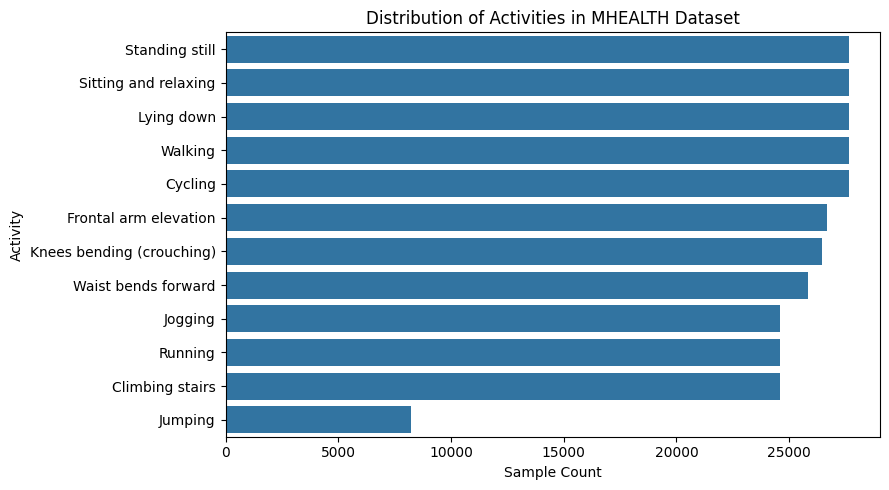

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 5))
sns.countplot(data=df, y='activity_name', order=df['activity_name'].value_counts().index)
plt.title("Distribution of Activities in MHEALTH Dataset")
plt.xlabel("Sample Count")
plt.ylabel("Activity")
plt.tight_layout()
plt.show()


In [8]:
df.head()

,acc_chest_x,acc_chest_y,acc_chest_z,ecg_1,ecg_2,acc_ankle_x,acc_ankle_y,acc_ankle_z,gyro_ankle_x,gyro_ankle_y,...,acc_wrist_z,gyro_wrist_x,gyro_wrist_y,gyro_wrist_z,mag_wrist_x,mag_wrist_y,mag_wrist_z,activity_label,subject,activity_name
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,0.187760,-0.44902,-1.0103,0.034483,-2.35000,-1.610200,-0.030899,0,1,NaN
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,1,NaN
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,1,NaN
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,1,NaN
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,1,NaN


In [9]:
df["acc_chest_total"] = np.sqrt(df["acc_chest_x"]**2 + df["acc_chest_y"]**2 + df["acc_chest_z"]**2)
high_impact = df["acc_chest_total"] > 3.5

fatigue = ((df["activity_label"].isin([0, 1])) &
           ((df["ecg_1"].abs() > 0.5) | (df["ecg_2"].abs() > 0.5)))

df["is_dynamic"] = df["activity_label"].isin([4, 5])
df["repetitive_stress"] = df["is_dynamic"].rolling(window=150, min_periods=1).sum() > 100

gyro_instability = df[["gyro_wrist_x", "gyro_wrist_y", "gyro_wrist_z"]].std(axis=1) > 2.5

df["risk_label"] = (high_impact | fatigue | df["repetitive_stress"] | gyro_instability).astype(int)

# STEP 3: NORMALIZE SENSOR FEATURES

val_subjects = df["subject"].unique()[:2]
val_df = df[df["subject"].isin(val_subjects)].copy()
train_df = df[~df["subject"].isin(val_subjects)].copy()

# Exclude 'activity_name' from feature_cols
feature_cols = [col for col in df.columns if col not in ['activity_label', 'subject', 'risk_label', 'activity_name']]  # 🔄 CHANGED: Excluded 'activity_name'

scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])

# STEP 4: SEGMENT INTO WINDOWS
# Function to create windows
def create_windows(df, feature_cols, label_col, window_size=100, stride=50):
    X_windows, y_windows = [], []
    for i in range(0, len(df) - window_size, stride):
        window = df.iloc[i:i+window_size]
        X = window[feature_cols].values
        y = window[label_col].mode()[0]
        X_windows.append(X)
        y_windows.append(y)
    return np.stack(X_windows), np.array(y_windows)

X_train, y_train = create_windows(train_df, feature_cols, 'risk_label')
X_val, y_val = create_windows(val_df, feature_cols, 'risk_label')

# Balance the training set
risky_idxs = np.where(y_train == 1)[0]
safe_idxs = np.where(y_train == 0)[0]
min_len = min(len(risky_idxs), len(safe_idxs))
sel_risk = resample(risky_idxs, n_samples=min_len, replace=False, random_state=42)
sel_safe = resample(safe_idxs, n_samples=min_len, replace=False, random_state=42)
idxs = np.concatenate([sel_risk, sel_safe])
X_train, y_train = X_train[idxs], y_train[idxs]

# Convert to PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32).permute(0, 2, 1)
y_val = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)


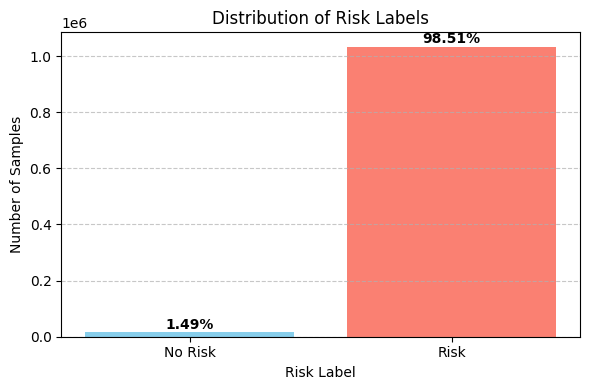

In [11]:
import matplotlib.pyplot as plt

label_counts = df["risk_label"].value_counts().sort_index()
labels = ["No Risk", "Risk"]
values = label_counts.values
total = sum(values)

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=['skyblue', 'salmon'])

# Add percentages on top of bars
for bar, value in zip(bars, values):
    percent = f"{(value/total)*100:.2f}%"
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2000, percent,
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Distribution of Risk Labels")
plt.xlabel("Risk Label")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Epoch 1 - Loss: 0.7064
Epoch 2 - Loss: 0.6296
Epoch 3 - Loss: 0.2652
Epoch 4 - Loss: 0.0544
Epoch 5 - Loss: 0.0360
Epoch 6 - Loss: 0.0296
Epoch 7 - Loss: 0.0341
Epoch 8 - Loss: 0.0159
Epoch 9 - Loss: 0.0335
Epoch 10 - Loss: 0.0081

📊 Final Metrics:
Accuracy : 0.8223
Precision: 1.0000
Recall   : 0.8223
F1 Score : 0.9025

Confusion matrix values:
 [[   0    0]
 [1037 4798]]


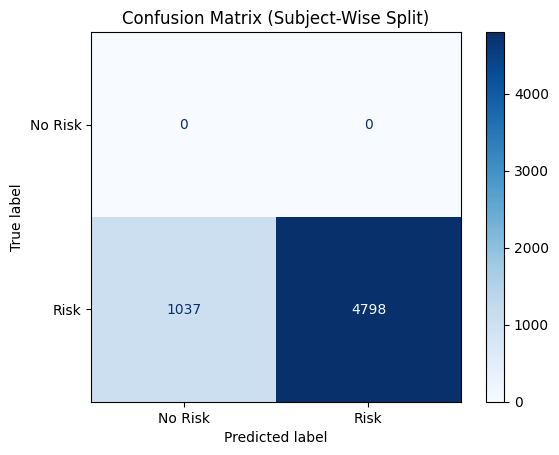

In [14]:
# STEP 6: DEFINE 1D CNN MODEL
class InjuryRisk1DCNN(nn.Module):  # 🔄 CHANGED: renamed model class
    def __init__(self, input_channels, num_classes):
        super(InjuryRisk1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(self.fc1(x))
        return self.fc2(x)

# STEP 7: TRAINING SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InjuryRisk1DCNN(input_channels=X_train.shape[1], num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_labels = torch.argmax(preds, dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(pred_labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n📊 Final Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix values:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Risk", "Risk"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Subject-Wise Split)")
plt.show()



